In [162]:
import DiadFit as pf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines

# Let's assume two FI, one trapped at HM and one at SC and temperatures spanning the whole range for ol-sat liquids at Kilauea (1100-1350 C)
- We assumed initially a temp of 1150 C (prior to SEM data), the average SEM-EDS measured Temp based on FO for the Sept 10th eruption was 1240 C

In [172]:
from scipy.optimize import newton

XH2O=None
EOS='SW96'

average_meas_T_K=1240+273.15 # this is the average SEM-EDS measured Temp based on FO for the Sept 10th eruption
assumed_T_K=1150+273.15 # Our initial guess based on past eruption

# Find the CO2 density approximate at 1150 C and 4 and 1.5 km depths (HM and SC average depths)

def find_co2_density_for_depth(T_K, desired_depth_km=4.0, initial_CO2_dens_gcm3=0.2, tolerance=0.001,EOS='SW96',XH2O=0):

    # Define the function to minimize (the difference between desired_depth_km and the actual depth)
    def depth_difference(co2_dens_gcm3,XH2O=XH2O):
        if XH2O!=0:
            result_df = pf.convert_co2_dens_press_depth(XH2O=XH2O, CO2_dens_gcm3=co2_dens_gcm3, T_K=T_K, crust_dens_kgm3=2300)
        else:
            result_df = pf.convert_co2_dens_press_depth(EOS=EOS, CO2_dens_gcm3=co2_dens_gcm3, T_K=T_K, crust_dens_kgm3=2300)
        current_depth_km = result_df.loc[0, 'Depth (km)']

        return current_depth_km - desired_depth_km

    # Use newton to find the root of depth_difference
    result = newton(depth_difference, x0=initial_CO2_dens_gcm3, tol=tolerance)

    return result


co2_dens_4km = find_co2_density_for_depth(T_K=assumed_T_K, desired_depth_km=4.0, initial_CO2_dens_gcm3=0.2, tolerance=0.0001,EOS=EOS,XH2O=XH2O)
co2_dens_1km = find_co2_density_for_depth(T_K=assumed_T_K, desired_depth_km=1.5, initial_CO2_dens_gcm3=0.2, tolerance=0.0001,EOS=EOS,XH2O=XH2O)

co2_dens_4km



0.2732543017304524

## Now let's propagate error based on the whole range of temps for erupted ol-sat liquids at Kilauea (1100-1350C)
- assume crust density 2300 kg/m3, error only on T

working on sample number 0
working on sample number 0
working on sample number 0
working on sample number 0


,Filename,CO2_dens_gcm3,SingleFI_D_km,SingleFI_P_kbar,Mean_MC_P_kbar,Med_MC_P_kbar,std_dev_MC_P_kbar,std_dev_MC_P_kbar_from_percentile,Mean_MC_D_km,Med_MC_D_km,std_dev_MC_D_km,std_dev_MC_D_km_from_percentile,error_T_K,error_CO2_dens_gcm3,error_crust_dens_kgm3,T_K,CO2_dens_gcm3_input,model,crust_dens_kgm3,EOS
0,HM_FI,0.116377,1.444289,0.325875,0.326894,0.325883,0.031933,0.030622,1.448807,1.444323,0.141526,0.135720,125.0,0,0.0,1373.15,0.116377,None,2300,SW96
1,SC_FI,0.273254,3.843783,0.867273,0.864319,0.862543,0.091285,0.085838,3.830693,3.822821,0.404579,0.380436,125.0,0,0.0,1373.15,0.273254,None,2300,SW96


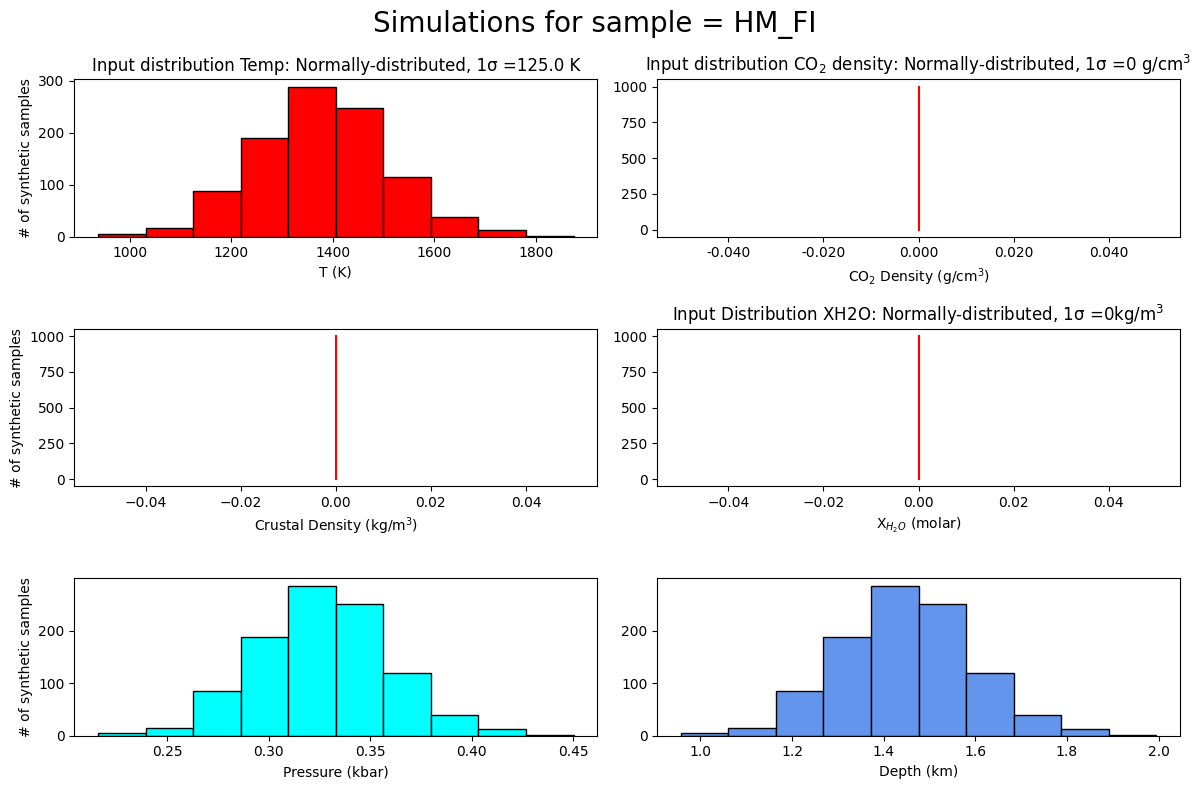

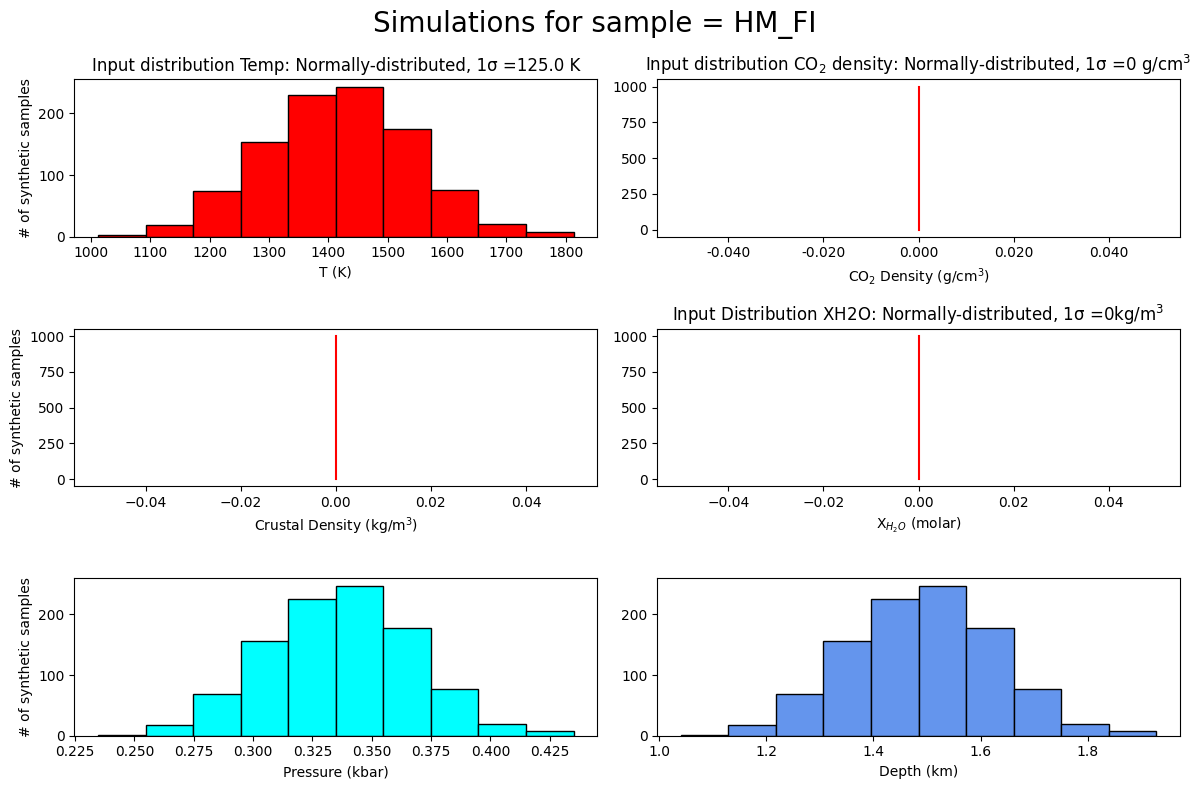

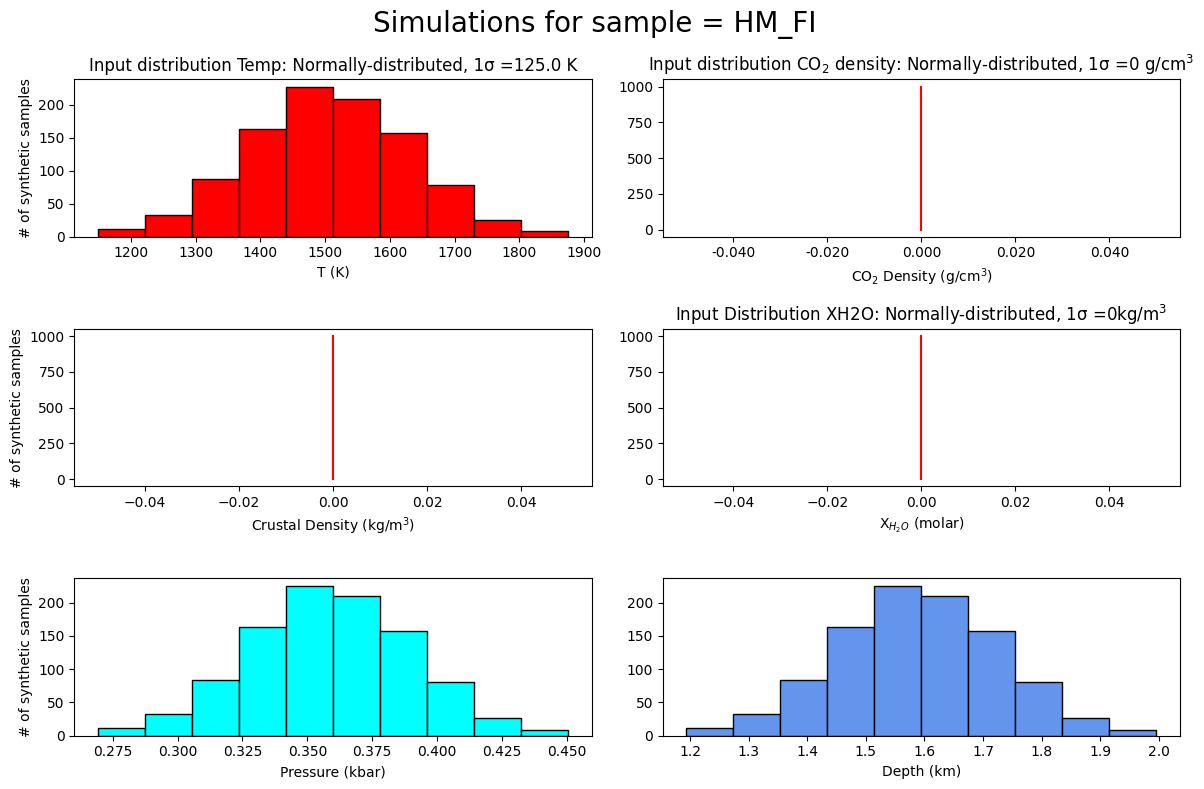

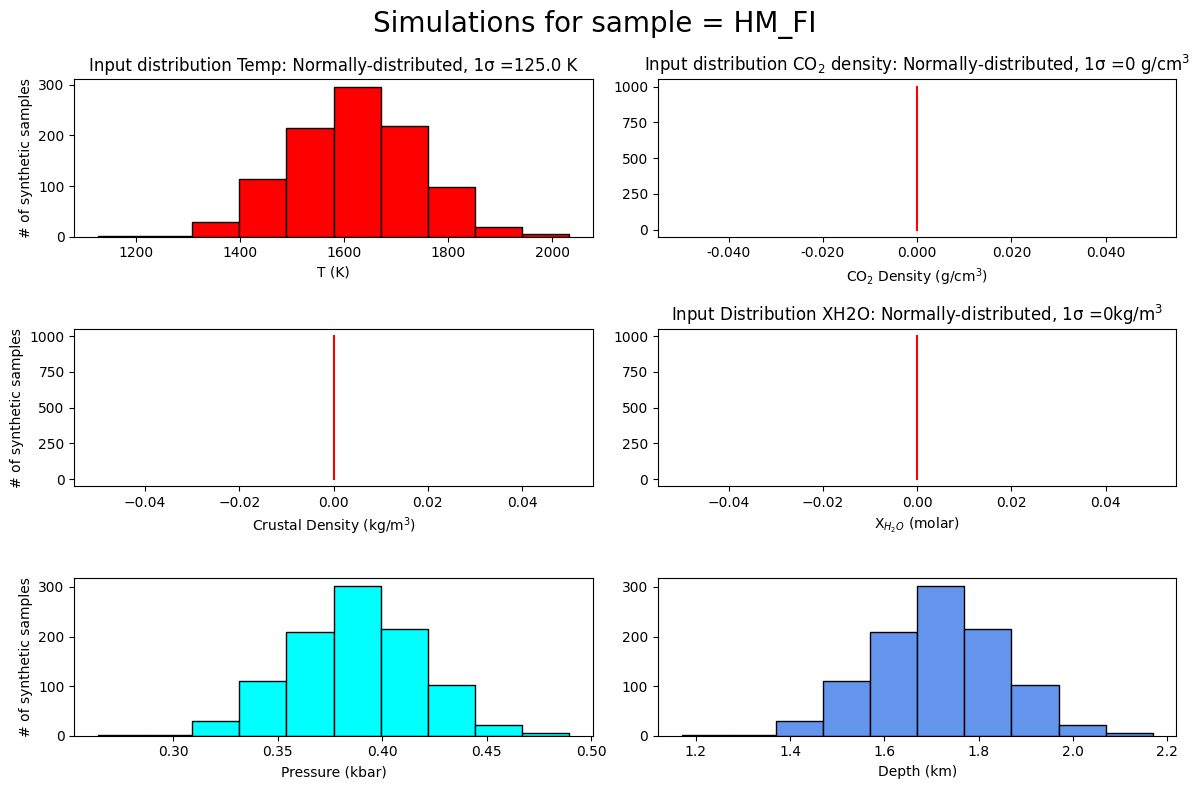

In [173]:
rhos=np.linspace(0.001,1.4,1000) # set range of densities for plotting later

T=[1100,1150,1240,1350] # set range of temps
T_K=[t+273.15 for t in T]

# Calculate single pressures and depths for whole range of densities

P_values = [pf.convert_co2_dens_press_depth(XH2O=XH2O, EOS=EOS,CO2_dens_gcm3=rhos, T_K=T_K[i], crust_dens_kgm3=2300) for i in range(len(T_K))]

# Montecarlo the errors for just the example FI (stars on graphs)

MC_P_starFI=[pf.propagate_FI_uncertainty(T_K=T_K[i],
error_T_K=(T_K[T_K.index(max(T_K))]-T_K[T_K.index(min(T_K))])/2, error_type_T_K='Abs', error_dist_T_K='normal',
                        CO2_dens_gcm3=pd.Series([co2_dens_1km,co2_dens_4km]),
                        sample_ID=pd.Series(['HM_FI','SC_FI']),
                        crust_dens_kgm3=2300,
                        XH2O=XH2O,EOS=EOS,
                        N_dup=1000, fig_i=0, plot_figure=True)[0] for i in range(len(T_K))]

MC_P_starFI[0]

## Version with 4 panels

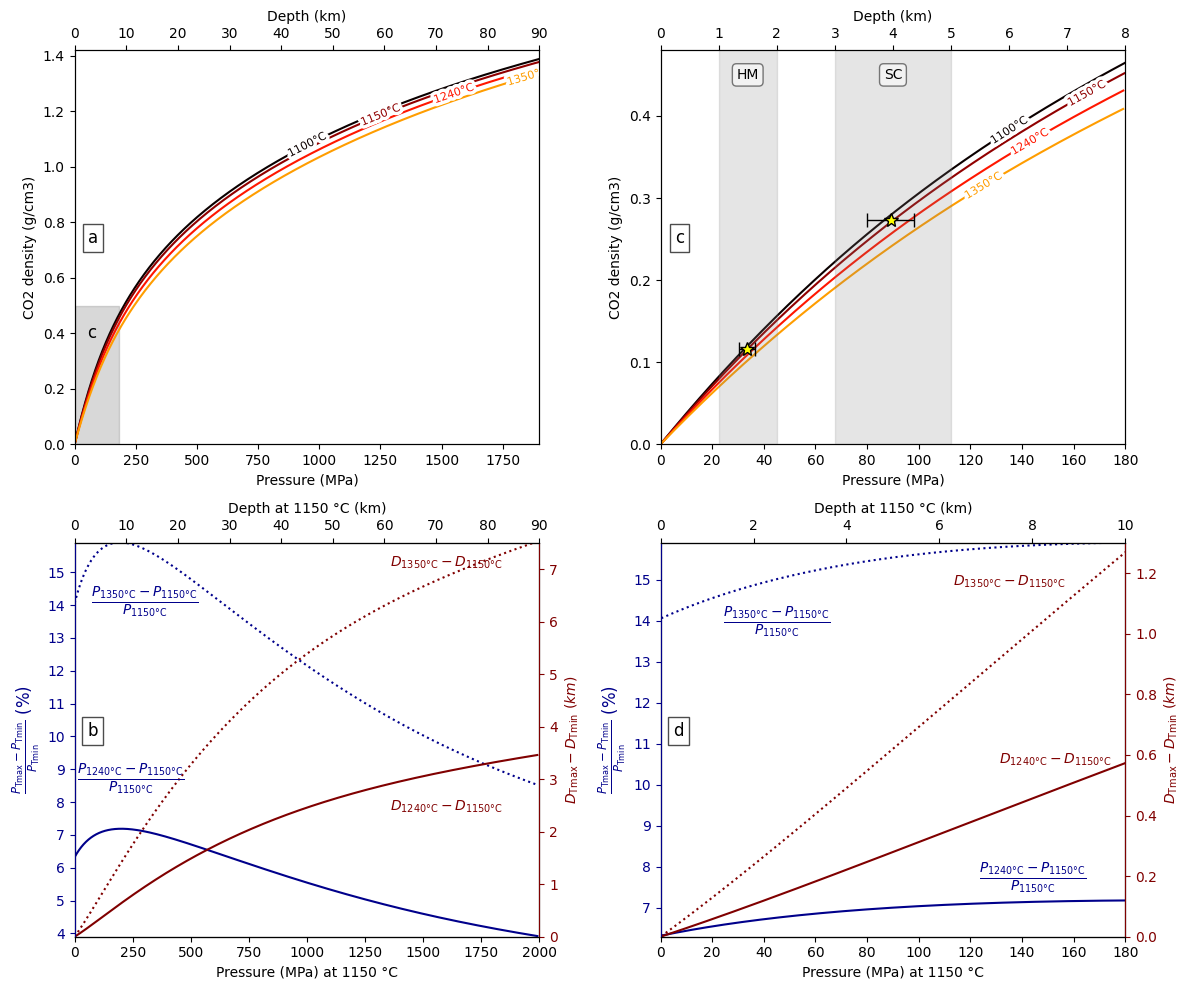

In [171]:
from matplotlib.ticker import MultipleLocator

# Color scale for temperature curves
colors = plt.cm.hot(np.linspace(0, 0.6, len(T_K)))

fig, ((ax1,ax3),(ax5,ax8)) = plt.subplots(2,2,figsize=(12,10))

#### Plot panel a ##########

min_P_ax1=0
max_P_ax1=2000 
# Plotting CO2 density against Pressure on the left y-axis
for i in range(len(T_K)):
    ax1.plot(P_values[i]['Pressure (MPa)'][P_values[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], P_values[i]['MC_CO2_dens_gcm3'][P_values[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], label=f'{T[i]}°C', color=colors[i])

# Secondary x-axis for depth in kilometers
ax2 = ax1.twiny()
for i in range(len(T_K)):
    ax2.plot(P_values[i]['Depth (km)'][P_values[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], P_values[i]['MC_CO2_dens_gcm3'][P_values[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], color='none')

ax1.set_xlabel('Pressure (MPa)')
ax2.set_xlabel('Depth (km)')
ax1.set_ylabel('CO2 density (g/cm3)')


ax1.set_ylim(np.round([min(P_values[0]['MC_CO2_dens_gcm3'][P_values[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values[0]['MC_CO2_dens_gcm3'][P_values[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])+0.02],2))

ax1.set_xlim(np.round([min(P_values[0]['Pressure (MPa)'][P_values[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values[0]['Pressure (MPa)'][P_values[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])],-2))
ax2.set_xlim(np.round([min(P_values[0]['Depth (km)'][P_values[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values[0]['Depth (km)'][P_values[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])],-1))


m=250
labelLines(ax1.get_lines(), zorder=3, xvals=[700+m,1000+m,1300+m,1600+m], fontsize=8)

# add panel indicator letter
bbox_props = dict(boxstyle='square', facecolor='white', edgecolor='k', alpha=0.7)
ax1.text(0.05, 0.50, 'a', transform=ax1.transAxes, fontsize=12, va='bottom', ha='right',bbox=bbox_props)

# plot the insert box corresponding to panel c on panel a

min_P_ax2 = 0
max_P_ax2 = 180
maxrho=round(max(P_values[0]['MC_CO2_dens_gcm3'][P_values[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),1)

x_coordinates = [0, max_P_ax2]
y_coordinates = [0, maxrho]
text_box_coords = [x_coordinates[0] + 50, y_coordinates[1] -0.1]

ax1.fill_between(x_coordinates, 0, y_coordinates[1], color='gray', alpha=0.3)
ax1.text(*text_box_coords, 'c', fontsize=12, va='center', ha='left')

############## Now plot panel c #############

for i in range(len(T_K)):
    ax3.plot(P_values[i]['Pressure (MPa)'][P_values[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], P_values[i]['MC_CO2_dens_gcm3'][P_values[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], label=f'{T[i]}°C', color=colors[i])

# secondary x-axis for depth in kilometers
ax4 = ax3.twiny()
for i in range(len(T_K)):
    ax4.plot(P_values[i]['Depth (km)'][P_values[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], P_values[i]['MC_CO2_dens_gcm3'][P_values[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], color='none')

ax3.set_xlabel('Pressure (MPa)')
ax4.set_xlabel('Depth (km)')
ax3.set_ylabel('CO2 density (g/cm3)')

ax4.xaxis.set_major_locator(MultipleLocator(1))
ax3.xaxis.set_major_locator(MultipleLocator(20))

ylims_ax2=np.round([min(P_values[0]['MC_CO2_dens_gcm3'][P_values[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values[0]['MC_CO2_dens_gcm3'][P_values[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])+0.02],2)

ax3.set_ylim(ylims_ax2)
ax3.set_xlim(np.round([min(P_values[0]['Pressure (MPa)'][P_values[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values[0]['Pressure (MPa)'][P_values[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])],-1))
ax4.set_xlim(np.round([min(P_values[0]['Depth (km)'][P_values[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values[0]['Depth (km)'][P_values[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])]))

ax4.fill_between([1, 2], ylims_ax2[0],ylims_ax2[1], color='gray', alpha=0.2, zorder=-1)
ax4.fill_between([3, 5], ylims_ax2[0],ylims_ax2[1], color='gray', alpha=0.2, zorder=-1)

labelLines(ax3.get_lines(), zorder=3, xvals=[max_P_ax2-45, max_P_ax2-15, max_P_ax2-37,max_P_ax2-55], fontsize=8)

# Add reservoir indicator boxes within the filled areas
ax4.text(1.5, maxrho-0.05, 'HM', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,boxstyle='round'),zorder=2)
ax4.text(4, maxrho-0.05, 'SC', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,boxstyle='round'),zorder=2)

ax4.errorbar(MC_P_starFI[1]['Mean_MC_D_km'],MC_P_starFI[1]['CO2_dens_gcm3'],xerr=MC_P_starFI[1]['std_dev_MC_D_km'],fmt='*',zorder=3,markersize=10,ecolor='k',capsize=5,mfc='yellow',mec='k',elinewidth=1)

ax3.text(0.05, 0.50, 'c', transform=ax3.transAxes, fontsize=12, va='bottom', ha='right',bbox=bbox_props)


############## plot panel b ########################

filter=[P_values[1]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]
ax5.plot(P_values[1]['Pressure (MPa)'],100*((P_values[3]['Pressure (MPa)']/P_values[1]['Pressure (MPa)'])-1),color='darkblue',linestyle=':') # For guess vs 1350

ax5.plot(P_values[1]['Pressure (MPa)'],100*((P_values[2]['Pressure (MPa)']/P_values[1]['Pressure (MPa)'])-1),color='darkblue',linestyle='-') # FOr average measured FI vs guess

ax6=ax5.twinx()
ax6.plot(P_values[1]['Pressure (MPa)'],100*((P_values[3]['Pressure (MPa)']/P_values[1]['Pressure (MPa)'])-1),color='none')

ax6.plot(P_values[1]['Pressure (MPa)'],P_values[3]['Depth (km)']-P_values[1]['Depth (km)'],color='maroon',linestyle=':')
ax6.plot(P_values[1]['Pressure (MPa)'],P_values[2]['Depth (km)']-P_values[1]['Depth (km)'],color='maroon')


ax5.set_xlim(np.round([min(P_values[0]['Pressure (MPa)']),max(P_values[0]['Pressure (MPa)'])],-1))

ax7=ax5.twiny()
ax7.plot(P_values[1]['Depth (km)'],100*((P_values[3]['Pressure (MPa)']/P_values[1]['Pressure (MPa)'])-1),color='none')

xlims_ax5=np.round([min(P_values[1]['Pressure (MPa)']),max(P_values[1]['Pressure (MPa)'])],-2)
ax5.set_xlim(np.round([min(P_values[1]['Pressure (MPa)'][P_values[1]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values[1]['Pressure (MPa)'][P_values[1]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])],-2))
ax7.set_xlim(np.round([min(P_values[1]['Depth (km)'][P_values[1]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values[1]['Depth (km)'][P_values[1]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])],-1))

ax5.set_ylim(np.round([min(100*((P_values[2]['Pressure (MPa)']/P_values[1]['Pressure (MPa)'])-1)),max(100*((P_values[3]['Pressure (MPa)']/P_values[1]['Pressure (MPa)'])-1))],1))
ax6.set_ylim(np.round([min(P_values[2]['Depth (km)']-P_values[1]['Depth (km)']),max(P_values[3]['Depth (km)']-P_values[1]['Depth (km)'])],1))

ax5.yaxis.set_major_locator(MultipleLocator(1))

ax6.set_ylabel(r'${D_{\text{Tmax}} - D_{\text{Tmin}}} \ (km)$',color='maroon')
ax5.set_ylabel(r'$\frac{P_{\text{Tmax}} - P_{\text{Tmin}}}{P_{\text{Tmin}}} \ (\%)$',color='darkblue',fontsize=12)
ax5.set_xlabel('Pressure (MPa) at 1150 °C')
ax7.set_xlabel('Depth at 1150 °C (km)')

ax6.tick_params(axis='y', color='maroon',labelcolor='maroon')
ax7.spines['right'].set_color('maroon')

ax5.tick_params(axis='y', color='darkblue',labelcolor='darkblue')
ax7.spines['left'].set_color('darkblue')

ax7.text(0.05, 0.50, 'b', transform=ax7.transAxes, fontsize=12, va='bottom', ha='right',bbox=bbox_props)

# r'${D_{\text{1350°C}} - D_{\text{1100°C}}} \ (km)$'
ax7.text(0.8, 0.95, r'${D_{\text{1350°C}} - D_{\text{1150°C}}}$', transform=ax7.transAxes, ha='center', va='center', fontsize=10,color='maroon')
ax7.text(0.8, 0.33, r'${D_{\text{1240°C}} - D_{\text{1150°C}}}$', transform=ax7.transAxes, ha='center', va='center', fontsize=10,color='maroon')

ax7.text(0.15, 0.85, r'$\frac{P_{\text{1350°C}} - P_{\text{1150°C}}}{P_{\text{1150°C}}}$', transform=ax7.transAxes, ha='center', va='center', fontsize=14,color='darkblue')
ax7.text(0.12, 0.4, r'$\frac{P_{\text{1240°C}} - P_{\text{1150°C}}}{P_{\text{1150°C}}}$', transform=ax7.transAxes, ha='center', va='center', fontsize=14,color='darkblue')

############## plot panel d ########################

Pvals_filt=P_values #[df[df['Pressure (MPa)'].between(min_P_ax2, max_P_ax2+1)] for df in P_values]

ax8.plot(Pvals_filt[1]['Pressure (MPa)'],100*((Pvals_filt[3]['Pressure (MPa)']/Pvals_filt[1]['Pressure (MPa)'])-1),color='darkblue',linestyle=':') # For guess vs 1350

ax8.plot(Pvals_filt[1]['Pressure (MPa)'],100*((Pvals_filt[2]['Pressure (MPa)']/Pvals_filt[1]['Pressure (MPa)'])-1),color='darkblue',linestyle='-') # FOr average measured FI vs guess

ax9=ax8.twinx()
ax9.plot(Pvals_filt[1]['Pressure (MPa)'],100*((Pvals_filt[3]['Pressure (MPa)']/Pvals_filt[1]['Pressure (MPa)'])-1),color='none')

ax9.plot(Pvals_filt[1]['Pressure (MPa)'],Pvals_filt[3]['Depth (km)']-Pvals_filt[1]['Depth (km)'],color='maroon',linestyle=':')
ax9.plot(Pvals_filt[1]['Pressure (MPa)'],Pvals_filt[2]['Depth (km)']-Pvals_filt[1]['Depth (km)'],color='maroon')


ax10=ax8.twiny()
ax10.plot(Pvals_filt[1]['Depth (km)'],100*((Pvals_filt[3]['Pressure (MPa)']/Pvals_filt[1]['Pressure (MPa)'])-1),color='none')

ax8.set_xlim(np.round([min(Pvals_filt[1]['Pressure (MPa)'][Pvals_filt[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(Pvals_filt[1]['Pressure (MPa)'][Pvals_filt[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])],-1))
ax10.set_xlim(np.round([min(Pvals_filt[1]['Depth (km)'][Pvals_filt[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(Pvals_filt[1]['Depth (km)'][Pvals_filt[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])],-1))

ax8.set_ylim(np.round([min(100*((Pvals_filt[2]['Pressure (MPa)'][Pvals_filt[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]/Pvals_filt[1]['Pressure (MPa)'][Pvals_filt[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])-1)),max(100*((Pvals_filt[3]['Pressure (MPa)'][Pvals_filt[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]/Pvals_filt[1]['Pressure (MPa)'][Pvals_filt[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])-1))],1))
ax9.set_ylim(np.round([min(Pvals_filt[2]['Depth (km)'][Pvals_filt[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]-Pvals_filt[1]['Depth (km)'][Pvals_filt[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(Pvals_filt[3]['Depth (km)'][Pvals_filt[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]-Pvals_filt[1]['Depth (km)'][Pvals_filt[1]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])],1))


ax8.yaxis.set_major_locator(MultipleLocator(1))

ax9.set_ylabel(r'${D_{\text{Tmax}} - D_{\text{Tmin}}} \ (km)$',color='maroon')
ax8.set_ylabel(r'$\frac{P_{\text{Tmax}} - P_{\text{Tmin}}}{P_{\text{Tmin}}} \ (\%)$',color='darkblue',fontsize=12)
ax8.set_xlabel('Pressure (MPa) at 1150 °C')
ax10.set_xlabel('Depth at 1150 °C (km)')

ax9.tick_params(axis='y', color='maroon',labelcolor='maroon')
ax10.spines['right'].set_color('maroon')

ax8.tick_params(axis='y', color='darkblue',labelcolor='darkblue')
ax10.spines['left'].set_color('darkblue')

ax10.text(0.05, 0.50, 'd', transform=ax10.transAxes, fontsize=12, va='bottom', ha='right',bbox=bbox_props)

# r'${D_{\text{1350°C}} - D_{\text{1100°C}}} \ (km)$'
ax10.text(0.75, 0.90, r'${D_{\text{1350°C}} - D_{\text{1150°C}}}$', transform=ax10.transAxes, ha='center', va='center', fontsize=10,color='maroon')
ax10.text(0.85, 0.45, r'${D_{\text{1240°C}} - D_{\text{1150°C}}}$', transform=ax10.transAxes, ha='center', va='center', fontsize=10,color='maroon')

ax10.text(0.25, 0.80, r'$\frac{P_{\text{1350°C}} - P_{\text{1150°C}}}{P_{\text{1150°C}}}$', transform=ax10.transAxes, ha='center', va='center', fontsize=14,color='darkblue')
ax10.text(0.8, 0.15, r'$\frac{P_{\text{1240°C}} - P_{\text{1150°C}}}{P_{\text{1150°C}}}$', transform=ax10.transAxes, ha='center', va='center', fontsize=14,color='darkblue')


fig.tight_layout()

plt.show()

plt.rcParams["pdf.fonttype"]=42
# fig.savefig("FigS_Duan_10pH2O_Tsens.pdf")
# fig.savefig("FigS_SPTsens.pdf")
fig.savefig("FigS_SWTsens.pdf")

In [101]:
Pdiff_DZ06 = pd.DataFrame({
    'Pressure (MPa)': P_values[1]['Pressure (MPa)'],
    'Depth (km)': P_values[1]['Depth (km)'],
    'Pressure %diff (MPa)': 100*((P_values[3]['Pressure (MPa)']/P_values[1]['Pressure (MPa)'])-1),
    'Depth absolute diff (km)': P_values[3]['Depth (km)']-P_values[1]['Depth (km)']
})
Pdiff_DZ06.to_excel("Pressure_model_Duan_10pH2O.xlsx")
# Pdiff_DZ06.to_excel("Pressure_model_SP94.xlsx")
# Pdiff_DZ06.to_excel("Pressure_model_SW96.xlsx")



In [182]:
diffmax = pd.DataFrame({
    'Pressure (MPa)': P_values[1]['Pressure (MPa)'],
    'Depth (km)': P_values[1]['Depth (km)'],
    'Pressure %diff': 100*((P_values[3]['Pressure (MPa)']/P_values[1]['Pressure (MPa)'])-1),
    'Depth absolute diff (km)': P_values[3]['Depth (km)']-P_values[1]['Depth (km)']
})
diffmax[diffmax['Depth (km)'].between(4.9,5.1)]

,Pressure (MPa),Depth (km),Pressure %diff,Depth absolute diff (km)
228,110.604778,4.902042,15.689118,0.769087
229,111.241105,4.930244,15.692918,0.773699
230,111.879282,4.958529,15.696687,0.778325
231,112.519316,4.986895,15.700426,0.782964
232,113.161217,5.015344,15.704133,0.787616
233,113.804991,5.043877,15.707810,0.792283
234,114.450646,5.072492,15.711456,0.796962


In [102]:
dz=pd.read_excel("Pressure_model_Duan_10pH2O.xlsx")
sp=pd.read_excel("Pressure_model_SP94.xlsx")
sw=pd.read_excel("Pressure_model_SW96.xlsx")
sw

,Unnamed: 0,Pressure (MPa),Depth (km),Pressure %diff (MPa),Depth absolute diff (km)
0,0,0.269036,0.011924,14.060969,0.001677
1,1,0.646364,0.028647,14.071631,0.004031
2,2,1.024359,0.045400,14.082254,0.006393
3,3,1.403023,0.062182,14.092839,0.008763
4,4,1.782359,0.078995,14.103387,0.011141
...,...,...,...,...,...
995,995,1967.351309,87.193694,8.587597,7.487843
996,996,1973.277128,87.456328,8.572186,7.496919
997,997,1979.220199,87.719727,8.556795,7.505998
998,998,1985.180576,87.983893,8.541424,7.515077


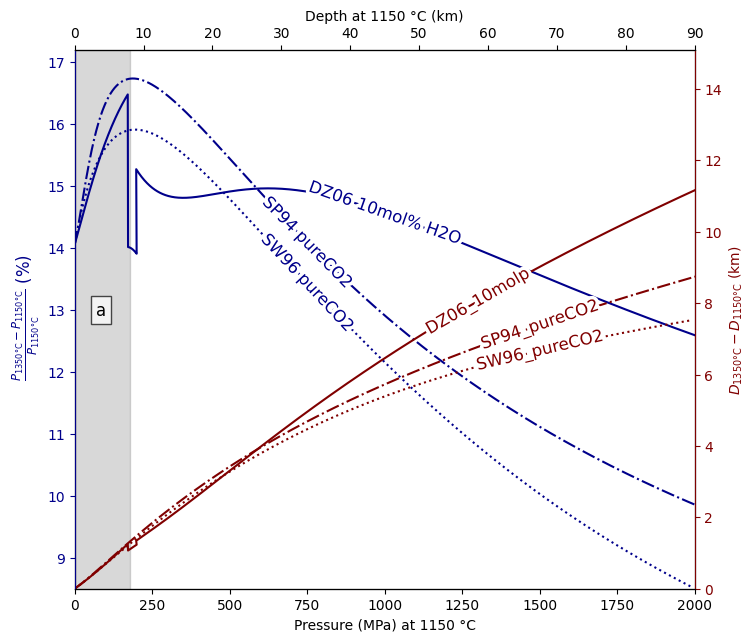

In [156]:
# Color scale for temperature curves
colors = plt.cm.hot(np.linspace(0, 0.6, len(T_K)))

dfs=[dz,sw,sp]

fig, ((ax5)) = plt.subplots(1,1,figsize=(8,7))

yvar='Pressure %diff (MPa)'
xvar='Pressure (MPa)'
twinxvar='Depth (km)'
twinyvar='Depth absolute diff (km)'
#### Plot panel a ##########

min_P_ax1=0
max_P_ax1=2000 

ax5.plot(dz[xvar],dz[yvar],color='darkblue',linestyle='-',label='DZ06 10mol% H2O') # For guess vs 1350
ax5.plot(sw[xvar],sw[yvar],color='darkblue',linestyle=':',label='SW96 pureCO2') # For guess vs 1350
ax5.plot(sp[xvar],sp[yvar],color='darkblue',linestyle='-.',label='SP94 pureCO2') # For guess vs 1350

labelLines(ax5.get_lines(), zorder=3, xvals=[1000,750,750], fontsize=12)

ax6=ax5.twinx()
ax6.plot(dz[xvar],dz[yvar],color='none')

ax6.plot(dz[xvar],dz[twinyvar],color='maroon',linestyle='-',label='DZ06_10molp')
ax6.plot(sw[xvar],sw[twinyvar],color='maroon',linestyle=':',label='SW96_pureCO2')
ax6.plot(sp[xvar],sp[twinyvar],color='maroon',linestyle='-.',label='SP94_pureCO2')

labelLines(ax6.get_lines(), zorder=3, xvals=[1300,1500,1500], fontsize=12)


ax7=ax5.twiny()
ax7.plot(dz[twinxvar],dz[yvar],color='none')

ax5.set_xlim(np.round([min(dz[xvar][dz[xvar].between(min_P_ax1,max_P_ax1)]),max(dz[xvar][dz[xvar].between(min_P_ax1,max_P_ax1)])],-2))
ax7.set_xlim(np.round([min(dz[twinxvar][dz[xvar].between(min_P_ax1,max_P_ax1)]),max(dz[twinxvar][dz[xvar].between(min_P_ax1,max_P_ax1)])],-1))

ax5.set_ylim(np.round([min(sw[yvar]),max(sp[yvar])+0.5],1))
ax6.set_ylim(np.round([min(dz[twinyvar]),max(dz[twinyvar])],1))

ax5.yaxis.set_major_locator(MultipleLocator(1))

ax6.set_ylabel(r'${D_{\text{1350°C}} - D_{\text{1150°C}}}$ (km)',color='maroon')
ax5.set_ylabel(r' $\frac{P_{\text{1350°C}} - P_{\text{1150°C}}}{P_{\text{1150°C}}}$ (%)',color='darkblue',fontsize=12)
ax5.set_xlabel('Pressure (MPa) at 1150 °C')
ax7.set_xlabel('Depth at 1150 °C (km)')

ax6.tick_params(axis='y', color='maroon',labelcolor='maroon')
ax7.spines['right'].set_color('maroon')

ax5.tick_params(axis='y', color='darkblue',labelcolor='darkblue')
ax7.spines['left'].set_color('darkblue')

ax7.text(0.05, 0.50, 'a', transform=ax7.transAxes, fontsize=12, va='bottom', ha='right',bbox=bbox_props)

min_P_ax2 = 0
max_P_ax2 = 180
maxsp=round(max(sp[yvar])+0.5,1)

x_coordinates = [0, max_P_ax2]
y_coordinates = [0, maxsp]
text_box_coords = [x_coordinates[0] + 50, y_coordinates[1] -5]

ax5.fill_between(x_coordinates, 0, y_coordinates[1], color='gray', alpha=0.3)

fig.savefig("FigS_Duan_SP_SW_Tcomp.pdf")

